In [ ]:
# Рубежный контроль №1
# Пименов Г.Ю. группа ИУ5-24М
# Вариант №8
# Используется набор данных, который содержит информацию о продажах видеоигр. 
# источник: https://www.kaggle.com/datasets/gregorut/videogamesales.

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline 
sns.set(style="ticks")

In [2]:
data = pd.read_csv("gamesales.csv")

In [3]:
data.head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


In [4]:
data.shape

(16598, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [6]:
data.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [7]:
data.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [11]:
# Пропущенные значения в стобцах Year и Publisher
# Задача 8:
# Для набора данных проведите устранение пропусков для одного (произвольного) числового признака
# с использованием метода заполнения модой

mode_value = data['Year'].mode()[0]

# Нашли наиболее часто встречающееся или "модное" значение в столбце

data['Year'].fillna(mode_value, inplace=True)

# Заменили пропуски на это значение

data.isna().sum()

Rank             0
Name             0
Platform         0
Year             0
Genre            0
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
Global_Sales     0
dtype: int64

In [12]:
# Как видим, пропуски в столбце Year пропали
# Повторим алгоритм для столбца Publisher

mode_value = data['Publisher'].mode()[0]
data['Publisher'].fillna(mode_value, inplace=True)
data.isna().sum()

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [14]:
# Задача 28:
# Для набора данных для одного (произвольного) числового признака проведите обнаружение и замену 
# (найденными верхними и нижними границами) выбросов на основе межквартильного размаха.

def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

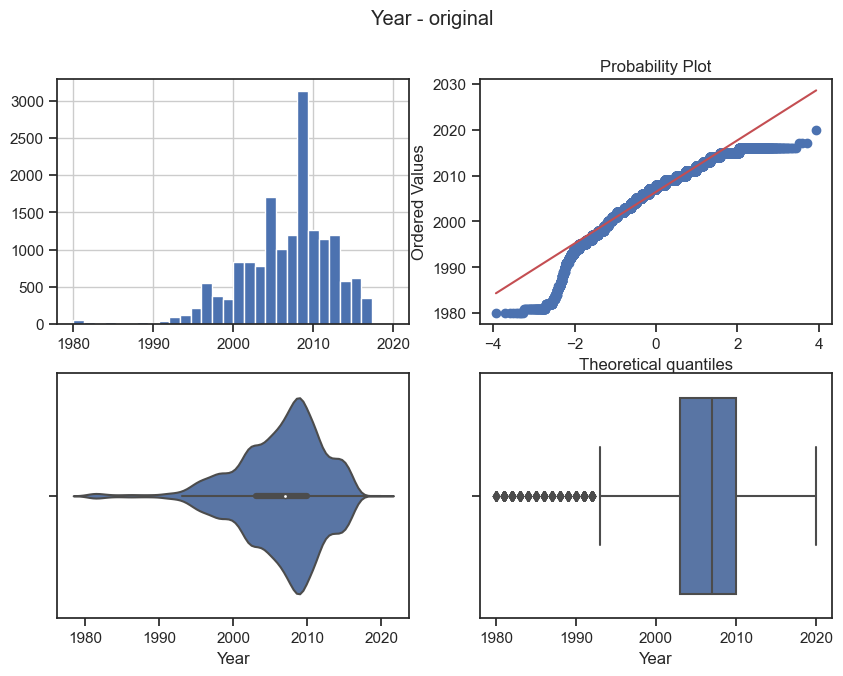

In [17]:
diagnostic_plots(data, 'Year', 'Year - original')

In [23]:
# Функция вычисления верхней и нижней границы выбросов

def get_outlier_boundaries(df, col):
  
  K2 = 1.5
  IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
  lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
  upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

  
  return lower_boundary, upper_boundary 

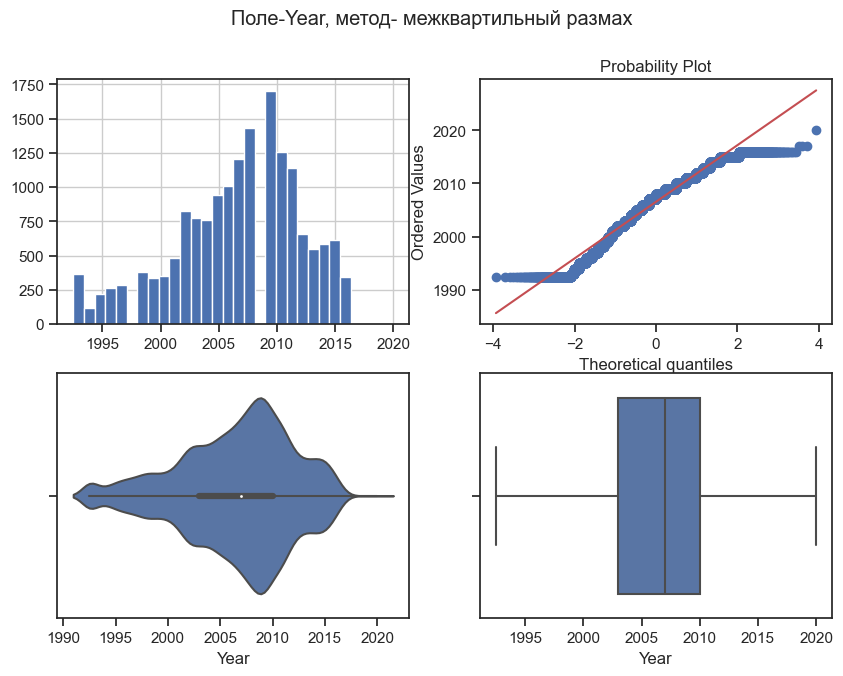

In [25]:
    col = 'Year'
    # Вычисление верхней и нижней границы
    lower_boundary, upper_boundary = get_outlier_boundaries(data, col)
    # Изменение данных
    data[col] = np.where(data[col] > upper_boundary, upper_boundary, 
                             np.where(data[col] < lower_boundary, lower_boundary, data[col]))
    title = 'Поле-{}, метод- межквартильный размах'.format(col)
    diagnostic_plots(data, col, title)

<AxesSubplot:xlabel='Year'>

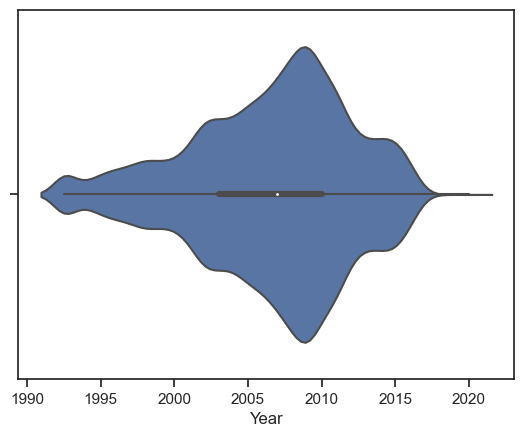

In [26]:
# Дополнительное задание: для произвольной колонки данных построить график "Скрипичная диаграмма (violin plot)".

sns.violinplot(x='Year', data=data)